# Bollinger's analysis and position limits

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
plt.style.use('seaborn')

## Getting csv data with historical ask, bid values

In [9]:
csv_filepath = 'test_data/f7ec8b80-9015-46cc-99d2-47efe80847ef.csv'
csv_trade = pd.read_csv(csv_filepath, sep=';')

In [10]:
df_banana = csv_trade[csv_trade['product'] == 'BANANAS'].sort_values(by=["timestamp"])
df_pearl = csv_trade[csv_trade['product'] == 'PEARLS'].sort_values(by=["timestamp"])

In [11]:
df_pearl.tail()

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
3991,-1,199500,PEARLS,9996,1,9995.0,21.0,NaN,NaN,9998,2,10004.0,1.0,10005.0,21.0,9997.0,3738.0
3992,-1,199600,PEARLS,9995,28,NaN,NaN,NaN,NaN,10005,28,NaN,NaN,NaN,NaN,10000.0,3742.0
3995,-1,199700,PEARLS,10002,1,9996.0,2.0,9995.0,28.0,10004,2,10005.0,28.0,NaN,NaN,10003.0,3742.0
3997,-1,199800,PEARLS,9996,1,9995.0,27.0,NaN,NaN,10004,1,10005.0,27.0,NaN,NaN,10000.0,3744.0
3999,-1,199900,PEARLS,9998,9,9995.0,25.0,NaN,NaN,10005,25,NaN,NaN,NaN,NaN,10001.5,3744.0


In [12]:
df_banana.tail()

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
3990,-1,199500,BANANAS,4930,22,NaN,NaN,NaN,NaN,4937,22,NaN,NaN,NaN,NaN,4933.5,2652.3477
3993,-1,199600,BANANAS,4930,28,NaN,NaN,NaN,NaN,4937,28,NaN,NaN,NaN,NaN,4933.5,2651.9492
3994,-1,199700,BANANAS,4931,30,NaN,NaN,NaN,NaN,4937,2,4938.0,28.0,NaN,NaN,4934.0,2647.6210
3996,-1,199800,BANANAS,4931,1,4930.0,27.0,NaN,NaN,4937,28,NaN,NaN,NaN,NaN,4934.0,2649.3809
3998,-1,199900,BANANAS,4931,9,4930.0,25.0,NaN,NaN,4932,3,4937.0,25.0,NaN,NaN,4931.5,2649.2969


In [13]:
csv_trade.groupby('product').agg({'mid_price': ['mean', 'std', 'min', 'max']})

mid_price                           
              mean       std     min      max
product                                      
BANANAS  4938.2895  7.958996  4924.5   4956.0
PEARLS   9999.9935  1.493427  9996.5  10003.5

## Getting log file to extract positions

In [14]:
positions = {
    'timestamp': [],
    'BANANAS': [],
    'PEARLS': [],
}
position_well_defined = False
position_taken = False
with open('test_data/f7ec8b80-9015-46cc-99d2-47efe80847ef.log', 'r') as logfile:
    for line in logfile.readlines():
        if 'state.own_trades' in line and position_well_defined:
            splitted_str = line.split("state.own_trades")
            try:
                timestamp = int(splitted_str[0])
                positions["timestamp"].append(timestamp)
                #print(timestamp)
            except ValueError:
                continue
            position_taken = False
        
        if "state.position" in line and not position_taken:
            current_position = line.split("state.position =")[1]
            #values = re.findall(r'\d+', line)
            values = re.findall(r'-?\d+\.?\d*', line)
            if len(values) == 0:
                continue
                #positions["BANANAS"].append(0)
                #positions["PEARLS"].append(0)
            elif len(values) == 1:
                position_taken = True
                position_well_defined = True
                if "BANANAS" in current_position:
                    positions["BANANAS"].append(float(values[0]))
                    positions["PEARLS"].append(0)
                if "PEARLS" in current_position:
                    positions["BANANAS"].append(0)
                    positions["PEARLS"].append(float(values[0]))
                    
            elif len(values) == 2:
                #print(values)
                position_taken = True
                position_well_defined = True
                positions["BANANAS"].append(float(values[0]))
                positions["PEARLS"].append(float(values[1]))

logfile.close()
# pop the latest ones
positions["PEARLS"].pop(-1)
positions["BANANAS"].pop(-1)
    
df_positions = pd.DataFrame(positions)

In [15]:
df_positions.head()

,timestamp,BANANAS,PEARLS
0,500,0.0,3.0
1,600,-9.0,3.0
2,700,-10.0,1.0
3,800,-10.0,1.0
4,900,-10.0,1.0


In [16]:
df_positions.tail()

,timestamp,BANANAS,PEARLS
1990,199500,-5.0,14.0
1991,199600,-5.0,10.0
1992,199700,-5.0,12.0
1993,199800,-5.0,12.0
1994,199900,-5.0,11.0


## Bollinger's band Analysis 
### First for Bananas

In [17]:
def SMA(data, period, column = 'mid_price'):
    return data[column].rolling(window = period).mean()

# Setting up Bananas DF
df_banana['SMA15'] = SMA(df_banana, 15)
df_banana['SMA50'] = SMA(df_banana, 50)
df_banana['SMA80'] = SMA(df_banana, 80)
df_banana['stdev'] = df_banana.mid_price.rolling(window = 15).std()
df_banana['Upper'] = df_banana.SMA15 + 1*df_banana.stdev
df_banana['Lower'] = df_banana.SMA15 - 1*df_banana.stdev 
 # Buy & Sell signals
df_banana['Buy_Signal'] = np.where(df_banana.Lower > df_banana.mid_price, True, False)
print("count BUY signal \n", df_banana.Buy_Signal.value_counts())
df_banana['Sell_Signal'] = np.where(df_banana.Upper < df_banana.mid_price, True, False)
print("count SELL signal \n", df_banana.Sell_Signal.value_counts())

count BUY signal 
 False    1669
True      331
Name: Buy_Signal, dtype: int64
count SELL signal 
 False    1693
True      307
Name: Sell_Signal, dtype: int64


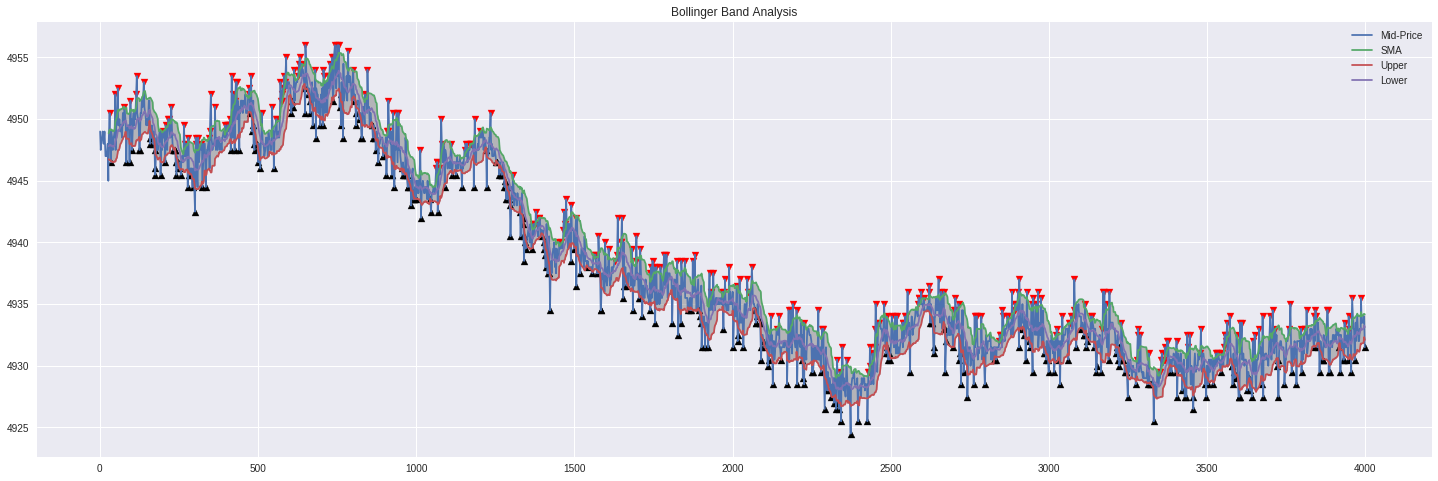

In [18]:
plt.figure(figsize = (25,8))
plt.plot(df_banana[['mid_price', 'Upper', 'Lower', 'SMA15']])
plt.fill_between(df_banana.index, df_banana.Upper, df_banana.Lower, color = 'grey', alpha = 0.5)
plt.scatter(df_banana.index[df_banana.Buy_Signal], df_banana[df_banana.Buy_Signal].mid_price, marker = '^', color = 'black')
plt.scatter(df_banana.index[df_banana.Sell_Signal], df_banana[df_banana.Sell_Signal].mid_price, marker = 'v', color = 'red')
plt.title('Bollinger Band Analysis')
plt.legend(['Mid-Price', 'SMA', 'Upper', 'Lower'])
plt.show()

Text(0.5, 1.0, 'Volume Over timestamp')

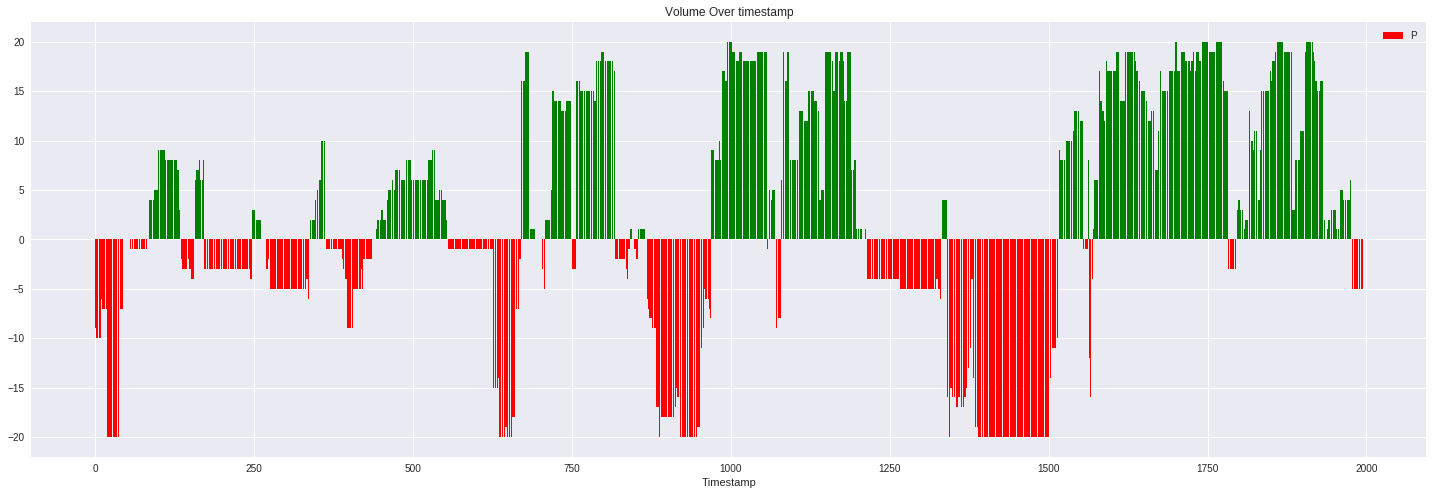

In [19]:
volume_plot = plt.figure(figsize=(25, 8))
#df_positions.plot.bar(y='BANANAS', use_index=True)
# creating the bar plot
palette = np.where(df_positions.BANANAS > 0, 'green', 'red')
plt.bar(df_positions.index, df_positions.BANANAS, color = palette)
plt.legend("Positions")
plt.xlabel("Timestamp")
plt.title("Volume Over timestamp")

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


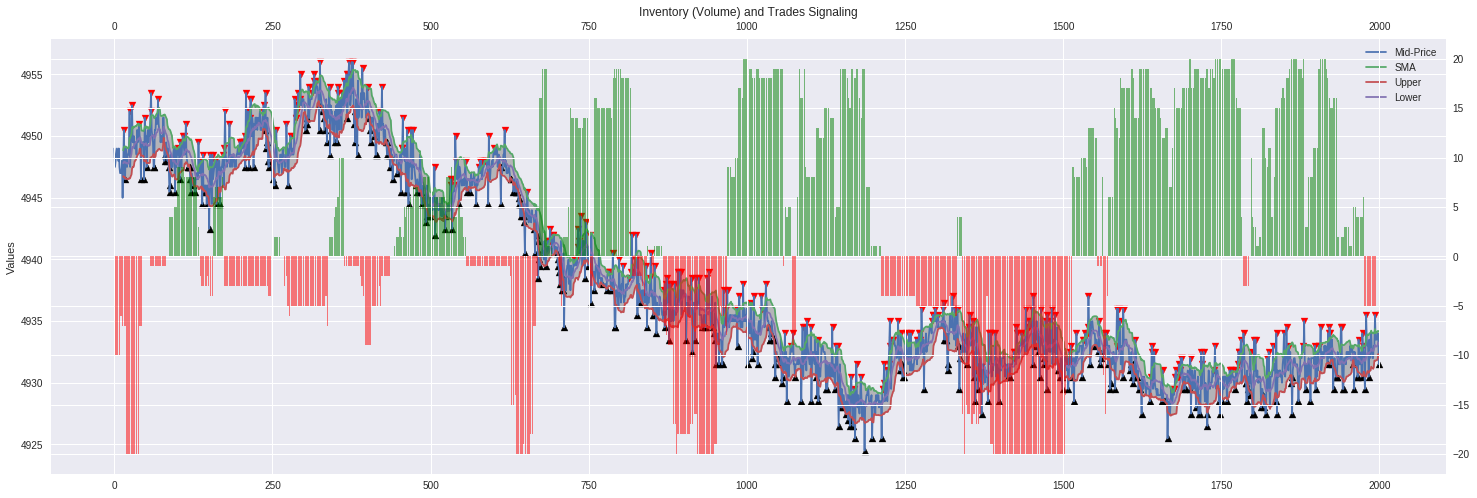

In [20]:
fig, ax = plt.subplots(figsize = (25,8))
ax.plot(df_banana.timestamp / 100, df_banana[['mid_price', 'Upper', 'Lower', 'SMA15']])
ax.set_ylabel("Values")
ax.fill_between(df_banana.timestamp / 100, df_banana.Upper, df_banana.Lower, color = 'grey', alpha = 0.5)
ax.scatter(df_banana.index[df_banana.Buy_Signal] / 2, df_banana[df_banana.Buy_Signal].mid_price, marker = '^', color = 'black')
ax.scatter(df_banana.index[df_banana.Sell_Signal] / 2, df_banana[df_banana.Sell_Signal].mid_price, marker = 'v', color = 'red')

ax.legend(['Mid-Price', 'SMA', 'Upper', 'Lower'])
ax_twinx, ax_twiny = ax.twinx(), ax.twiny()
ax_twinx.bar(df_positions.index, df_positions.BANANAS, color = palette, alpha=0.5)
ax_twiny.set_xlim(ax.get_xlim())
ax_twinx.set_xlabel("Positions")
plt.title('Inventory (Volume) and Trades Signaling')
plt.show()


# About the filled positions over timestamps

In [67]:
df_positions["diff_bananas"] = df_positions.BANANAS.diff()
print("Ratio of positions that do not change over a single timestamp (i.e. not filled) ")
len(df_positions.BANANAS[df_positions.BANANAS.diff() == 0])/len(df_positions.BANANAS)

Ratio of positions that do not change over a single timestamp (i.e. not filled) 


0.8280701754385965

Text(0, 0.5, 'Filled Amount')

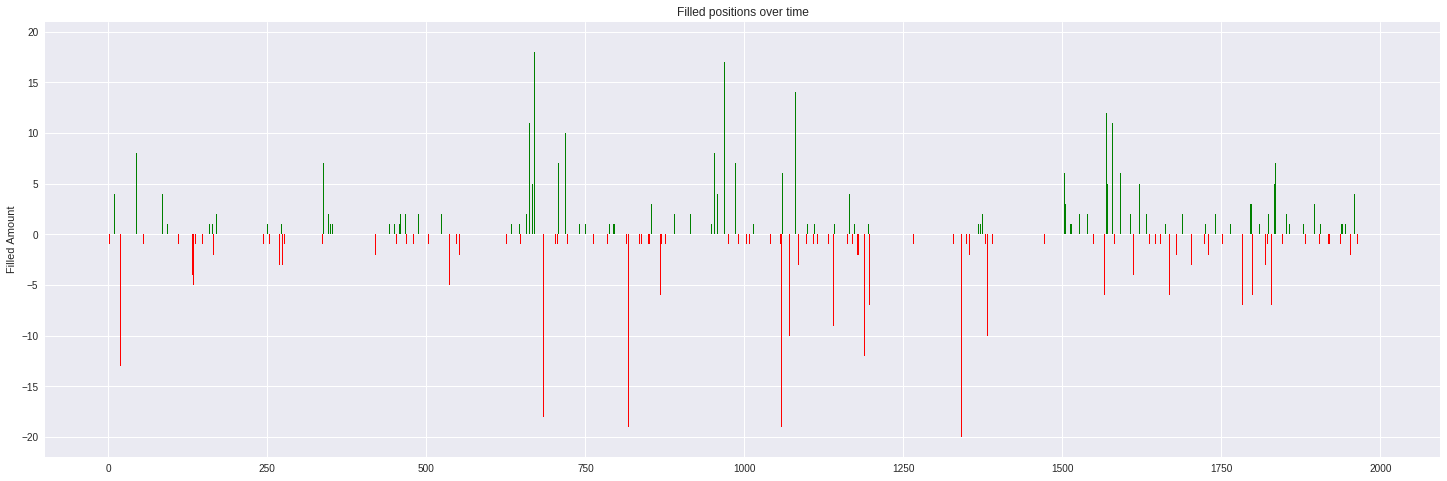

In [68]:
fig, ax = plt.subplots(figsize = (25,8))
palette = np.where(df_positions.diff_bananas > 0, 'green', 'red')
ax.bar(df_positions.index, df_positions.diff_bananas, color=palette)
plt.title("Filled positions over time")
ax.set_ylabel("Filled Amount")

# Here we aim to compute a Fill Ratio over time

Here we denote $P_i$ the position taken at timestamp $i$.

In [37]:
df_positions["fill_ratio"] = df_positions.BANANAS.diff(periods=1) / df_positions.BANANAS.shift(periods=1)

Text(0, 0.5, 'Fill Ratio')

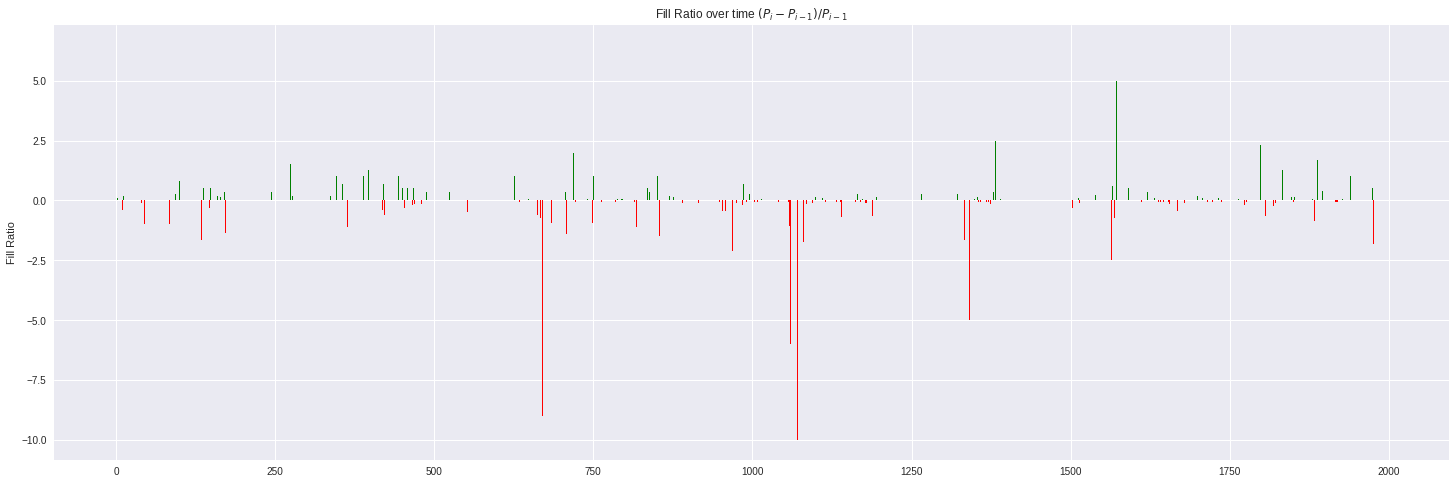

In [38]:
plt.rc('font', size=20)
fig, ax = plt.subplots(figsize = (25,8))
palette = np.where(df_positions.fill_ratio > 0, 'green', 'red')
ax.bar(df_positions.index, df_positions.fill_ratio, color=palette)
plt.title("Fill Ratio over time $(P_i - P_{i-1})/P_{i-1}$")
ax.set_ylabel(r"Fill Ratio")

In [40]:
# bid ratios
df_banana["spread"] = df_banana.ask_price_1 - df_banana.bid_price_1
df_banana["l1_ratio"] = df_banana.bid_volume_1 / df_banana.ask_volume_1
df_banana["l2_ratio"] = df_banana.bid_volume_2 / df_banana.ask_volume_2
df_banana["l3_ratio"] = df_banana.bid_volume_3 / df_banana.ask_volume_3

# Statistics for each Volume Level Ratio

In [54]:
metrics = ['count', 'mean', 'std', 'quantile']
df_banana.groupby("spread").agg({'l1_ratio': metrics, 'l2_ratio': metrics, 'l3_ratio': metrics})

l1_ratio                                l2_ratio                      \
          count      mean        std  quantile    count      mean       std   
spread                                                                        
1           184  8.836081  11.398767  1.633333       43  2.461717  5.276512   
2           117  1.534342   4.277655  0.130435       23  2.053342  3.620490   
3            40  7.585577   7.177978  5.450000        4  1.066953  0.030220   
4           102  2.689672   6.488271  0.250000       49  0.940402  0.018938   
5           292  6.457964   6.463925  4.333333       43  1.065516  0.022992   
6           643  6.057007   9.782331  0.310345        0       NaN       NaN   
7           622  0.997657   0.009393  1.000000        0       NaN       NaN   

                 l3_ratio                    
        quantile    count mean std quantile  
spread                                       
1       1.034483        0  NaN NaN      NaN  
2       1.000000        0  NaN NaN      NaN  
3       1.066288        0  NaN NaN      NaN  
4       0.935484        0  NaN NaN      NaN  
5       1.068966        0  NaN NaN      NaN  
6            NaN        0  NaN NaN      NaN  
7            NaN        0  NaN NaN      NaN

In [55]:
# bid ratios
# df_banana["l1_ratio"] = df_banana.bid_volume_1 / df_banana.ask_volume_1
# df_banana["l2_ratio"] = df_banana.bid_volume_2 / df_banana.ask_volume_2
# df_banana["l3_ratio"] = df_banana.bid_volume_3 / df_banana.ask_volume_3

df_banana['l1_ge_one'] = np.where(df_banana.l1_ratio > 1, True, False) # bullish
df_banana['l1_le_one'] = np.where(df_banana.l1_ratio < 1, True, False)

for col, verbose in zip(["l1_ratio", "l2_ratio", "l3_ratio"], ["LEVEL 1", "LEVEL 2", "LEVEL 3"]):
    print("Does {} has zeros: {}".format(col, df_banana[col].eq(0).any()))
    indicator_buy = df_banana['Buy_Signal'] & df_banana[col]
    print("count BUY signal (SMA & Volume Momentum) {}\n {}".format(verbose, indicator_buy.value_counts()))
    indicator_sell = df_banana['Sell_Signal'] & df_banana[col]
    print("count SELL signal (SMA & Volume Momentum) {}\n {}".format(verbose, indicator_sell.value_counts()))
    print("------ TEST -------")

print("------ USED HERE -------")
print("SMA & Volume Momentum for 1st LEVEL")
sma_and_volume_buy = df_banana['Buy_Signal'] & df_banana['l1_ge_one']
print("count BUY signal (SMA & Volume Momentum) \n", sma_and_volume_buy.value_counts())
sma_and_volume_sell = df_banana['Sell_Signal'] & df_banana['l1_le_one']
print("count SELL signal (SMA & Volume Momentum) \n", sma_and_volume_sell.value_counts())

Does l1_ratio has zeros: False
count BUY signal (SMA & Volume Momentum) LEVEL 1
 False    1669
True      331
dtype: int64
count SELL signal (SMA & Volume Momentum) LEVEL 1
 False    1693
True      307
dtype: int64
------ TEST -------
Does l2_ratio has zeros: False
count BUY signal (SMA & Volume Momentum) LEVEL 2
 False    1967
True       33
dtype: int64
count SELL signal (SMA & Volume Momentum) LEVEL 2
 False    1963
True       37
dtype: int64
------ TEST -------
Does l3_ratio has zeros: False
count BUY signal (SMA & Volume Momentum) LEVEL 3
 False    2000
dtype: int64
count SELL signal (SMA & Volume Momentum) LEVEL 3
 False    2000
dtype: int64
------ TEST -------
------ USED HERE -------
SMA & Volume Momentum for 1st LEVEL
count BUY signal (SMA & Volume Momentum) 
 False    1778
True      222
dtype: int64
count SELL signal (SMA & Volume Momentum) 
 False    1781
True      219
dtype: int64


## Using SMA 15 and Volume as Indicator

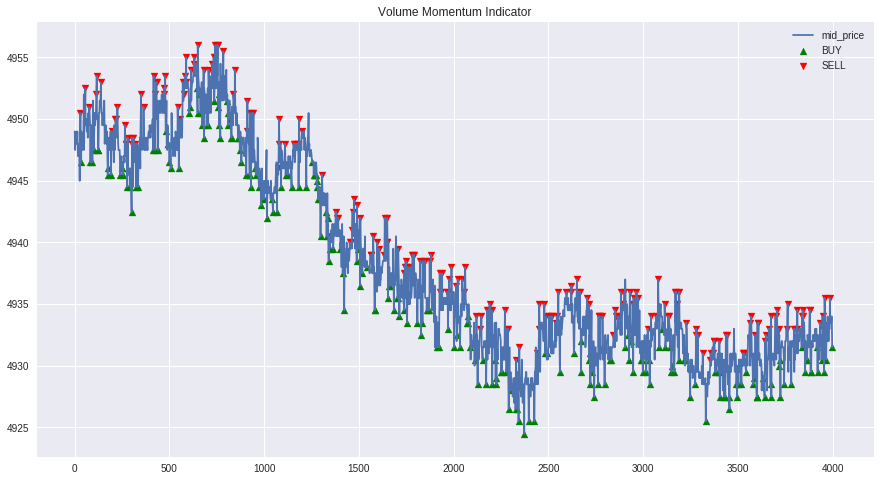

In [17]:
plt.figure(figsize = (15,8))
plt.plot(df_banana[['mid_price']])
#plt.fill_between(df_banana.index, df_banana.Upper, df_banana.Lower, color = 'grey', alpha = 0.5)
plt.scatter(df_banana[sma_and_volume_buy].index,df_banana[sma_and_volume_buy].mid_price, marker = '^', color = 'green')
plt.scatter(df_banana[sma_and_volume_sell].index, df_banana[sma_and_volume_sell].mid_price, marker = 'v', color = 'red')
plt.title('Volume Momentum Indicator')
plt.legend(["mid_price", "BUY", "SELL"])

### Now for pearls

In [18]:
def SMA(data, period, column = 'mid_price'):
    return data[column].rolling(window = period).mean()

# Setting up Bananas DF
df_pearl['SMA15'] = SMA(df_pearl, 15)
df_pearl['SMA50'] = SMA(df_pearl, 50)
df_pearl['SMA80'] = SMA(df_pearl, 80)
df_pearl['stdev'] = df_pearl.mid_price.rolling(window = 15).std()
df_pearl['Upper'] = df_pearl.SMA15 + 1*df_pearl.stdev # using 2 x standard deviation
df_pearl['Lower'] = df_pearl.SMA15 - 1*df_pearl.stdev
df_pearl['Buy_Signal'] = np.where(df_pearl.Lower > df_pearl.mid_price, True, False) # Buy & Sell signals
df_pearl['Sell_Signal'] = np.where(df_pearl.Upper < df_pearl.mid_price, True, False)

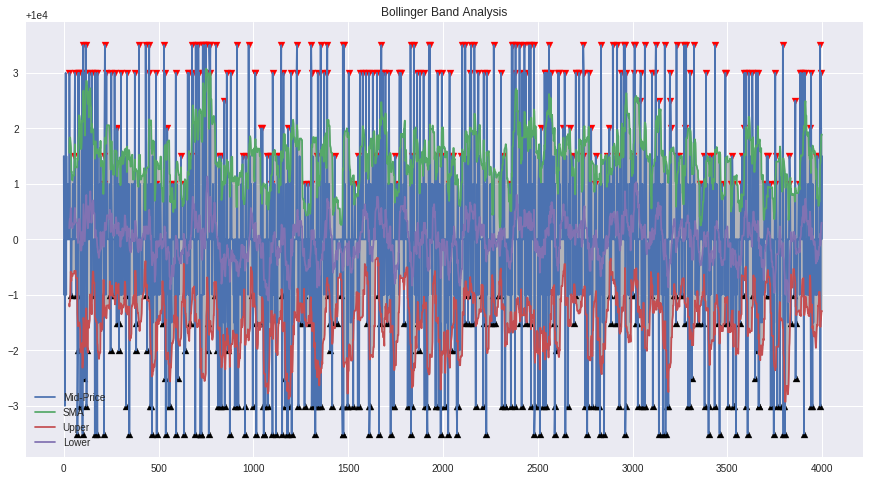

In [19]:
plt.figure(figsize = (15,8))
plt.plot(df_pearl[['mid_price', 'Upper', 'Lower', 'SMA15']])
plt.fill_between(df_pearl.index, df_pearl.Upper, df_pearl.Lower, color = 'grey', alpha = 0.5)
plt.scatter(df_pearl.index[df_pearl.Buy_Signal], df_pearl[df_pearl.Buy_Signal].mid_price, marker = '^', color = 'black')
plt.scatter(df_pearl.index[df_pearl.Sell_Signal], df_pearl[df_pearl.Sell_Signal].mid_price, marker = 'v', color = 'red')
plt.title('Bollinger Band Analysis')
plt.legend(['Mid-Price', 'SMA', 'Upper', 'Lower'])

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


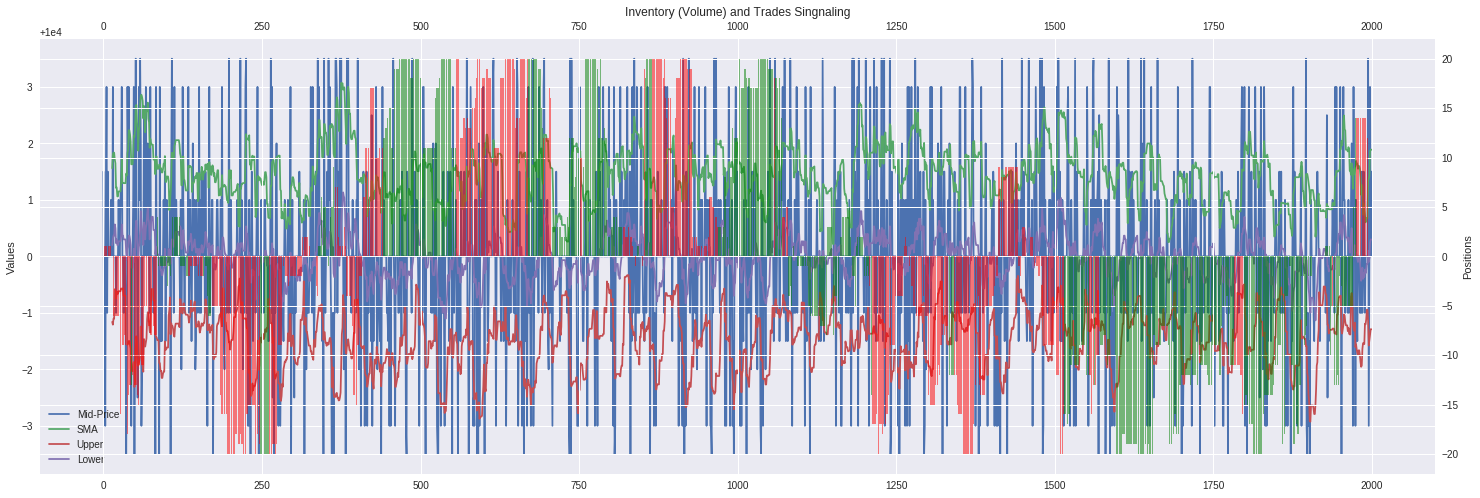

In [20]:
fig, ax = plt.subplots(figsize = (25,8))
ax.plot(df_pearl.timestamp / 100, df_pearl[['mid_price', 'Upper', 'Lower', 'SMA15']])
ax.set_ylabel("Values")
#ax.fill_between(df_pearl.timestamp / 100, df_pearl.Upper, df_pearl.Lower, color = 'grey', alpha = 0.5)
#ax.scatter(df_pearl.index[df_banana.Buy_Signal] / 2, df_pearl[df_banana.Buy_Signal].mid_price, marker = '^', color = 'black')
#ax.scatter(df_pearl.index[df_banana.Sell_Signal] / 2, df_pearl[df_banana.Sell_Signal].mid_price, marker = 'v', color = 'red')

ax.legend(['Mid-Price', 'SMA', 'Upper', 'Lower'])
ax_twinx, ax_twiny = ax.twinx(), ax.twiny()
ax_twinx.bar(df_positions.index, df_positions.PEARLS, color = palette, alpha=0.5)
ax_twiny.set_xlim(ax.get_xlim())
ax_twinx.set_ylabel("Positions")
plt.title('Inventory (Volume) and Trades Singnaling')
plt.show()


Text(0.5, 1.0, 'Volume Over timestamp')

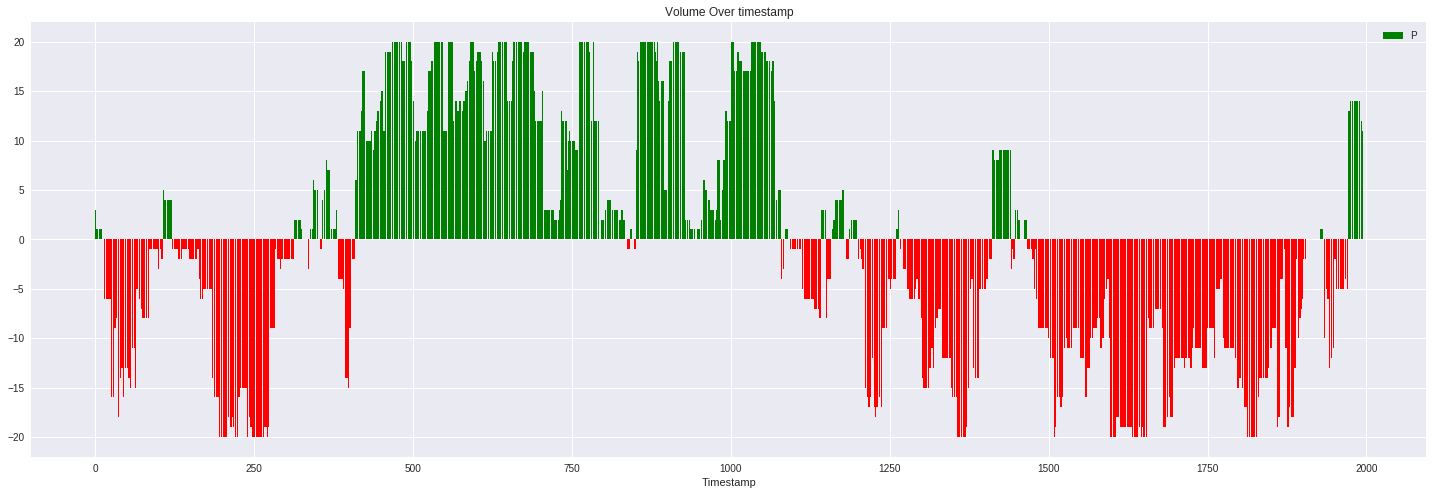

In [21]:
volume_plot = plt.figure(figsize=(25, 8))
#df_positions.plot.bar(y='BANANAS', use_index=True)
# creating the bar plot
palette = np.where(df_positions.PEARLS > 0, 'green', 'red')
plt.bar(df_positions.index, df_positions.PEARLS, color = palette)
plt.legend(r"Positions")
plt.xlabel(r"Timestamp")
plt.title("Volume Over timestamp")

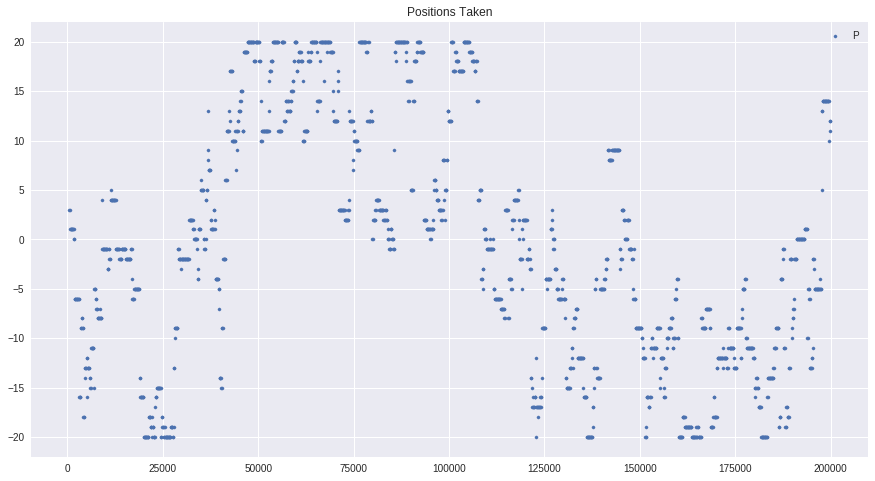

In [22]:
plt.figure(figsize = (15,8))
plt.scatter(df_positions['timestamp'], df_positions["PEARLS"], s=10)
plt.title('Positions Taken')
plt.legend("Positions", loc="best")

In [23]:
# bid ratios
df_pearl["l1_ratio"] = df_pearl.bid_volume_1 / df_pearl.ask_volume_1
df_pearl["l2_ratio"] = df_pearl.bid_volume_2 / df_pearl.ask_volume_2
df_pearl["l3_ratio"] = df_pearl.bid_volume_3 / df_pearl.ask_volume_3

df_pearl['l1_ge_one'] = np.where(df_pearl.l1_ratio > 1, True, False) # bullish
df_pearl['l1_le_one'] = np.where(df_pearl.l1_ratio < 1, True, False)

for col, verbose in zip(["l1_ratio", "l2_ratio", "l3_ratio"], ["LEVEL 1", "LEVEL 2", "LEVEL 3"]):
    print("Does {} has zeros: {}".format(col, df_pearl[col].eq(0).any()))
    indicator_buy = df_pearl['Buy_Signal'] & df_pearl[col]
    print("count BUY signal (SMA & Volume Momentum) {}\n {}".format(verbose, indicator_buy.value_counts()))
    indicator_sell = df_pearl['Sell_Signal'] & df_banana[col]
    print("count SELL signal (SMA & Volume Momentum) {}\n {}".format(verbose, indicator_sell.value_counts()))
    print("------ TEST -------")

print("------ USED HERE -------")
print("SMA & Volume Momentum for 1st LEVEL")
sma_and_volume_buy = df_pearl['Buy_Signal'] & df_pearl['l1_ge_one']
print("count BUY signal (SMA & Volume Momentum) \n", sma_and_volume_buy.value_counts())
sma_and_volume_sell = df_pearl['Sell_Signal'] & df_pearl['l1_le_one']
print("count SELL signal (SMA & Volume Momentum) \n", sma_and_volume_sell.value_counts())


Does l1_ratio has zeros: False
count BUY signal (SMA & Volume Momentum) LEVEL 1
 False    1719
True      281
dtype: int64
count SELL signal (SMA & Volume Momentum) LEVEL 1
 False    4000
dtype: int64
------ TEST -------
Does l2_ratio has zeros: False
count BUY signal (SMA & Volume Momentum) LEVEL 2
 False    1836
True      164
dtype: int64
count SELL signal (SMA & Volume Momentum) LEVEL 2
 False    4000
dtype: int64
------ TEST -------
Does l3_ratio has zeros: False
count BUY signal (SMA & Volume Momentum) LEVEL 3
 False    1999
True        1
dtype: int64
count SELL signal (SMA & Volume Momentum) LEVEL 3
 False    4000
dtype: int64
------ TEST -------
------ USED HERE -------
SMA & Volume Momentum for 1st LEVEL
count BUY signal (SMA & Volume Momentum) 
 False    1856
True      144
dtype: int64
count SELL signal (SMA & Volume Momentum) 
 False    1857
True      143
dtype: int64
